_Version log: Simulated Annealling._

In [1]:
import sys, time
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size':18, 'lines.markersize': 6.0, 'lines.linewidth': 2.0, 'figure.facecolor': 'none', 'axes.facecolor': 'white'})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
file_number = 25
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"

target, target_err = cs.open_dataset(file_name, ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"


In [3]:
reduced_points = 4
max_temp = 11
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
min_seperation= 1
iterations= 5000
cooling= 0.999
subsampling_method= "random"

In [4]:
#########INITAILISATION##########

start_time = time.time()

temps = []
scores = np.array([])
total_points = target.shape[-1]
detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
initialisation_detectors = np.copy(detectors)
score = new_score = cs.evaluate_score(detectors, target, target_err, regularization_coeffient= regularization_coeffient)
target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########
for n in tqdm(range(iterations)):
    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved
    new_score = cs.evaluate_score(new_detectors, target, target_err, regularization_coeffient)

    if new_score < score:
        detectors = new_detectors
        score = new_score
        improvement = True
        best_iteration = n

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

runtime = time.time() -start_time
print(f"Sim Annealing searched for {runtime} seconds and found a solution after {runtime *best_iteration/iterations} seconds")

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:15<00:00, 317.14it/s]

Sim Annealing searched for 15.819937229156494 seconds and found a solution after 2.847588701248169 seconds


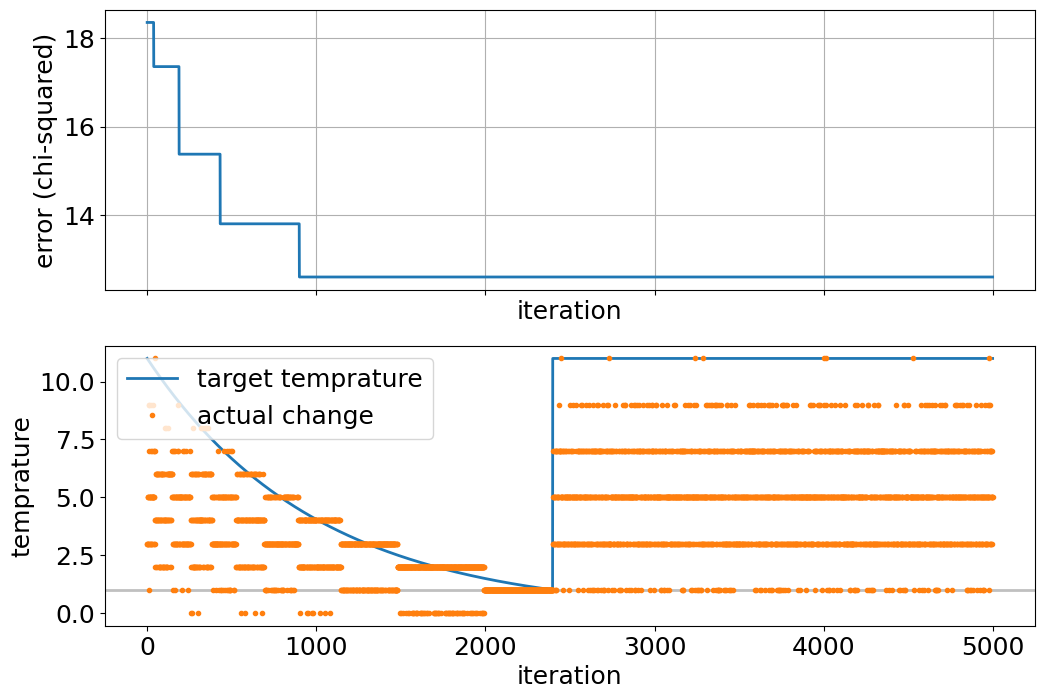

best score = 12.607


In [5]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (chi-squared)", xlabel= "iteration")

axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))

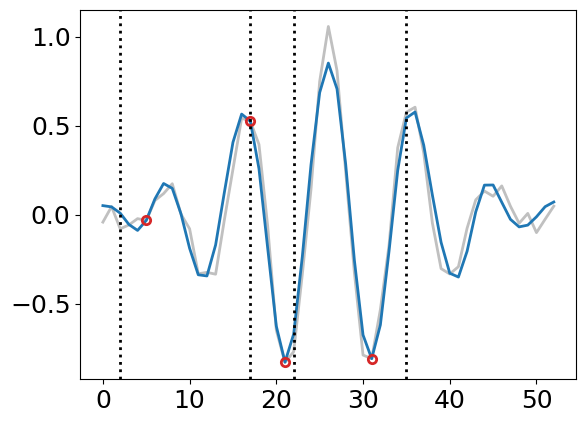

In [6]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

plt.plot(target, color= "silver")
plt.plot(result)
plt.plot(samples, marker= "o", linestyle= "none", markeredgecolor= "tab:red", markerfacecolor= "none", markeredgewidth= 2)
plt.vlines(initialisation_detectors, ymin= 0, ymax= 1, linestyle= ":", color= "k", transform= plt.gca().get_xaxis_transform())
plt.show()

In [7]:
cs.append_array_to_csv(detectors, optlocs_file)

print(*detectors, sep= ",")

5,17,21,31


## PROBIBLITY DISTROBUTION FOR WHERE THE SENSORS END UP AFTER SA OPTIMISATION

In [8]:
optlocs_file = "data\\1dmockanderrors15_randoptlocs.csv"
file_name = "1dmockanderrors15"

sensor_distrobution = cs.open_csv(optlocs_file, number_of_columns= 8)
target, uncertainties = cs.open_dataset(file_name, file_type)
total_point = len(target)
displacement = np.arange(-20.0, 20.0, 0.2) # 200 points, pixel pitch = 0.2 mm

In [9]:
frequent_locs = np.array(np.unique(sensor_distrobution, return_counts=True)).T
sensor_distrobution = sensor_distrobution[~np.isnan(sensor_distrobution)]
sensor_distrobution = sensor_distrobution *0.2 -20.0 #mm
#frequent_locs = frequent_locs[:-1] #remove nans
frequent_locs = frequent_locs[frequent_locs[:, 1].argsort()[::-1]]
#frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else np.nan for n in range(total_point)] # Put it back in order of sensor index.
#frequent_locs = np.array(frequent_locs)
print("Detector locations: Occurrences")
print(frequent_locs[:, :])

Detector locations: Occurrences
[[106 717]
 [ 92 675]
 [ 93 626]
 [ 99 595]
 [100 509]
 [ 86 464]
 [114 450]
 [ 85 439]
 [  3 437]
 [121 419]
 [195 415]
 [115 411]
 [196 410]
 [107 399]
 [  4 393]
 [ 11 369]
 [ 78 368]
 [ 79 367]
 [188 362]
 [ 18 358]
 [181 329]
 [ 46 324]
 [ 10 323]
 [ 25 310]
 [146 310]
 [ 32 310]
 [113 309]
 [189 308]
 [ 39 301]
 [174 295]
 [ 60 291]
 [ 67 288]
 [168 284]
 [160 283]
 [122 278]
 [ 31 274]
 [128 274]
 [153 274]
 [126 270]
 [ 87 270]
 [120 269]
 [167 269]
 [139 262]
 [ 47 261]
 [ 84 256]
 [ 71 254]
 [127 251]
 [152 248]
 [141 244]
 [138 242]
 [175 242]
 [ 50 241]
 [ 68 238]
 [131 237]
 [ 53 236]
 [149 233]
 [182 230]
 [145 225]
 [187 221]
 [132 220]
 [ 42 216]
 [ 27 211]
 [ 73 211]
 [ 19 209]
 [ 61 208]
 [ 17 207]
 [ 38 206]
 [ 12 205]
 [169 204]
 [161 204]
 [137 204]
 [172 203]
 [173 203]
 [ 62 202]
 [157 201]
 [ 26 199]
 [ 43 198]
 [180 196]
 [116 195]
 [ 44 195]
 [194 195]
 [ 16 192]
 [ 72 192]
 [159 191]
 [ 48 190]
 [166 190]
 [156 189]
 [143 189]


In [10]:
frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else 0 for n in range(total_point)] # Put it back in order of sensor index.
frequent_locs = np.array(frequent_locs)

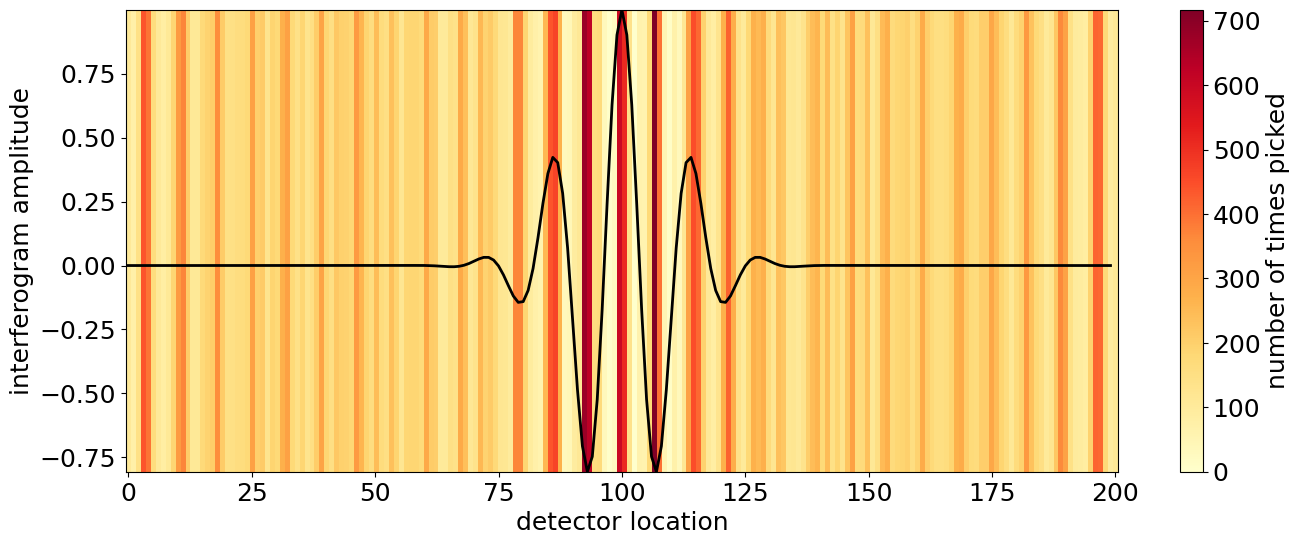

In [11]:
fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")

im = plt.imshow([frequent_locs], aspect= "auto", extent= (-0.5, total_point +0.5, min(target), max(target)), cmap= "YlOrRd")#, norm= "log")
plt.colorbar(im, label= "number of times picked")

axs.set(xlabel= "detector location", ylabel= "interferogram amplitude")
plt.show()

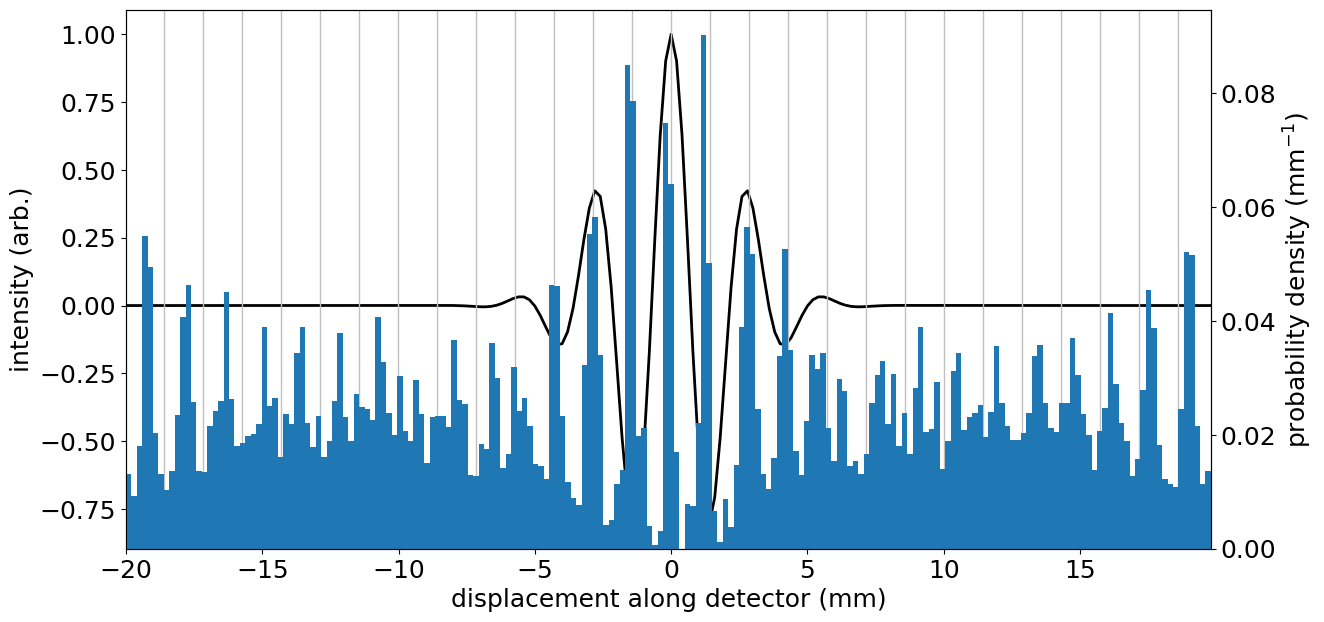

In [12]:
bins = int(total_point//1)

fig, axs = plt.subplots(figsize= (14,7))

axs.plot(displacement, target, color= "k", linewidth= 2, label= "interferogram")
axs.set(xlabel= "displacement along detector (mm)", ylabel= "intensity (arb.)", xlim= (-20.0, 19.8))
axs.vlines(np.arange(-15, 15) /0.6986, ymin= 0, ymax= 1, colors= "silver", linestyles= "-", linewidth= 1.0, transform= axs.get_xaxis_transform()) # 0.7mm^-1 is the nyquist spatial frequency for the central wavelength (3 THz, 0.35mm^-1 or 0.07 pixels^-1)

twinax = axs.twinx()
#twinax.plot(frequent_locs, linestyle= "None", marker= "x", markersize= 8)
twinax.hist(sensor_distrobution, bins= bins, density= True)
twinax.set(ylabel= "probability density (mm$^{-1}$)")

plt.show()